In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy import stats
from sklearn.decomposition import PCA
import random

from mpl_toolkits.mplot3d import *
import ipywidgets as widgets
from ipywidgets import interact, interactive, Dropdown
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
#preprocessing and import
df = pd.read_csv('/Users/albert/Documents/GitHub/housing_analysis/house-data/train.csv')
df = df[ df.select_dtypes(include=np.number).columns.tolist()]
df.dropna(inplace=True)

In [3]:
def pca_dec(data, n):
  pca = PCA(n)
  X_dec = pca.fit_transform(data)
  return X_dec, pca

#Decomposing the train set:
pca_train_results, pca_train = pca_dec(df, 10)

#Creating a table with the explained variance ratio
names_pcas = [f"PCA Component {i}" for i in range(1, 11, 1)]
scree = pd.DataFrame(list(zip(names_pcas, pca_train.explained_variance_ratio_)), columns=["Component", "Explained Variance Ratio"])

df_new = pd.DataFrame({'PCA':pca_train.components_[0], 'Variable Names':list(df.columns)})
df_new = df_new.sort_values('PCA', ascending=False)

In [4]:
#Sorting the absolute values of the first principal component by magnitude
df2 = pd.DataFrame(df_new)
df2['PCA']=df2['PCA'].apply(np.absolute)
df2 = df2.sort_values('PCA', ascending=False)
df_new.head()

,PCA,Variable Names
37,0.999535,SalePrice
3,0.029625,LotArea
16,0.004449,GrLivArea
12,0.003306,TotalBsmtSF
13,0.002830,1stFlrSF


In [5]:
def regress(degree, attribute):
    measured = df["SalePrice"]
    model = {}
    xp = np.linspace(1, df[attribute].max()+df[attribute].mean()/4, 20)
    
    data_reg = np.polyfit(df[attribute], df["SalePrice"], degree)
    predicted = np.polyval(data_reg, df[attribute].tolist())
    
    if degree == 1:
        #use pearson
        model[attribute] = [data_reg, predicted, stats.pearsonr(predicted, measured)[0], attribute]
    
    elif degree == 2:
        #use spearman
        model[attribute] = [data_reg, predicted, stats.spearmanr(predicted, measured)[0], attribute]
        
    return model

In [6]:
def mean_correlation(feature_collection:dict):
    #pc_info = {feature_name: [degree, correlation] for feature_name in features}
    n = len(feature_collection)
    avg_correlation = sum( np.array( list(feature_collection.values()) )[:,1] )/n
    return avg_correlation

In [7]:
def factor_test(degree:int, features:list):
    #feature_collection = {i:[] for i in features}
    
    feature_collection = {i:[degree, regress(degree, i)[i][2]] for i in features}
    return mean_correlation(feature_collection)

In [9]:
count = 0
n = 100
rank = 1
for i in range(n):
    features = [random.choice(df.keys()) for i in range(3)]
    count += factor_test(rank, features)
    
avg_c = count/n
print(avg_c)

0.30015359430892746


In [25]:
#list of features ordered by PCA rank, first element(salesprice removed)
PCA_features = df_new["Variable Names"].tolist()[1:]

In [28]:
n_used = [i for i in range(1,len(df.keys())+1)]

n_corr = []

for n in n_used:
    n_corr.append( factor_test(1, PCA_features[:n]) )

In [34]:
n_ran_used = [i for i in range(1, len(df.keys())+1)]
n_ran_corr = []

for n in n_ran_used:
    count = 0
    m = 100
    rank = 1
    for i in range(m):
        features = [random.choice(df.keys()) for i in range(n)]
        count += factor_test(rank, features)

    avg_c = count/m
    n_ran_corr.append(avg_c)

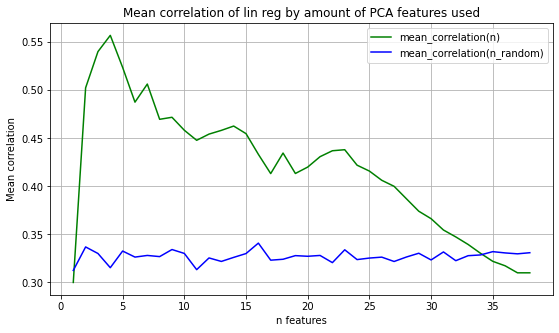

In [35]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot()
#plotting functions with the label parameter.
ax.plot(n_used, n_corr, color="green", label="mean_correlation(n)")
ax.plot(n_ran_used, n_ran_corr, color = "blue", label="mean_correlation(n_random)")
ax.set_xlabel("n features")
ax.set_ylabel("Mean correlation")
ax.set_title("Mean correlation of lin reg by amount of PCA features used")
#renders legends in the plot
ax.legend() 
ax.grid()

In [ ]:
fig = plt.figure(figsize=(14,9))
ax = plt.axes()
plt.scatter(df[attribute], df["SalePrice"], label = f"degree : correlation", color="black")
for i in range(1, rank+1):
    ax.plot(xp, np.polyval(model[i][0], xp), label = f"{i} : {round(model[i][2], 5)}", color = COLORS[i-1] )
    
ax.set_ylim(bottom=0, top = df["SalePrice"].max()+df["SalePrice"].mean()/4)
ax.set_xlim(0, df[attribute].max()+df[attribute].mean()/4)
ax.set_title("")
ax.set_title(f"SalePrice vs {attribute}")
ax.set_xlabel(f"{attribute}")
ax.set_ylabel("SalePrice")
ax.grid()
ax.legend()

In [ ]:
fig = plt.figure(figsize=(14,9))
ax = plt.axes()
#plt.scatter(df[attribute], df["SalePrice"], label = f"degree : correlation", color="black")
for i in range(1, rank+1):
    ax.plot(xp, np.polyval(model[i][0], xp), label = f"{i} : {round(model[i][2], 5)}", color = COLORS[i-1] )
    
ax.set_ylim(bottom=0, top = df["SalePrice"].max()+df["SalePrice"].mean()/4)
ax.set_xlim(0, df[attribute].max()+df[attribute].mean()/4)
ax.set_title("")
ax.set_title(f"SalePrice vs {attribute}")
ax.set_xlabel(f"{attribute}")
ax.set_ylabel("SalePrice")
ax.grid()
ax.legend()

In [ ]:
# identifiers for top 3 features
PCA_features = df_new["Variable Names"].tolist()[1:4]

# identifiers for top 10 features
PCA_features_top10 = df_new["Variable Names"].tolist()[1:11]

# identifiers for top 20 features
PCA_features_top20 = df_new["Variable Names"].tolist()[1:21]

In [11]:
#interactive plotter
attribute = Dropdown(options = df.keys())
@interact(rank = (1, 6), attribute = attribute)
def g(rank, attribute):
    measured = df["SalePrice"]
    COLORS = ["red", "blue", "green", "orange", "yellow", "gray", "cyan", "purple"]
    model = {}
    xp = np.linspace(1, df[attribute].max()+df[attribute].mean()/4, 20)
    for i in range(1, rank+1):
        data_reg = np.polyfit(df[attribute], df["SalePrice"], i)
        predicted = np.polyval(data_reg, df[attribute].tolist())
        if i == 1:
            model[i] = [data_reg,
                             predicted,
                             stats.pearsonr(predicted, measured)[0]]
        
        
        elif i > 1:
            model[i] = [data_reg,
                             predicted,
                             stats.spearmanr(predicted, measured)[0]]
    
    fig = plt.figure(figsize=(14,9))
    ax = plt.axes()
    plt.scatter(df[attribute], df["SalePrice"], label = f"degree : correlation", color="black")
    for i in range(1, rank+1):
        ax.plot(xp, np.polyval(model[i][0], xp), label = f"{i} : {round(model[i][2], 5)}", color = COLORS[i-1] )
    
    ax.set_ylim(bottom=0, top = df["SalePrice"].max()+df["SalePrice"].mean()/4)
    ax.set_xlim(0, df[attribute].max()+df[attribute].mean()/4)
    ax.set_title("")
    ax.set_title(f"SalePrice vs {attribute}")
    ax.set_xlabel(f"{attribute}")
    ax.set_ylabel("SalePrice")
    ax.grid()
    ax.legend()

interactive(children=(IntSlider(value=3, description='rank', max=6, min=1), Dropdown(description='attribute', …